This is a revised and updated version of an [older post](http://rdkit.blogspot.com/2017/11/using-feature-maps.html).

This post provides a short demonstration of how to use the RDKit's feature map implementation to score aligned 3D conformations against each other based on the overlap of their pharmacophoric features.
The idea of the feature map is not a new one and there are numerous publications on the topic. These two come closest to describing the RDKit implementation:

1. Putta, S., Landrum, G. A. & Penzotti, J. E. "Conformation mining: An algorithm for finding biologically relevant conformations." *J. Med. Chem.* **48**, 3313–3318 (2005).
http://pubs.acs.org/doi/abs/10.1021/jm049066l
2. Landrum, G. A., Penzotti, J. E. & Putta, S. "Feature-map vectors: a new class of informative descriptors for computational drug discovery." *J. Comput. Aided. Mol. Des.* **20**, 751–762 (2007).
https://link.springer.com/article/10.1007/s10822-006-9085-8


In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit.Chem import Draw
import time
print(time.asctime())
from rdkit import rdBase
print(rdBase.rdkitVersion)

Fri Feb 24 09:44:30 2023
2022.09.4


For this post we'll use a set of three 5HT-3 ligands.

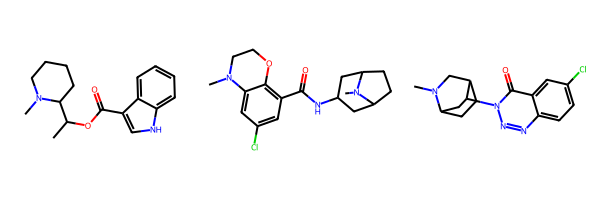

In [2]:
smis = ['CC(OC(=O)c1c[nH]c2ccccc12)C1CCCCN1C',
 'CN1CCOc2c(C(=O)NC3CC4CCC(C3)N4C)cc(Cl)cc21',
 'CN1CC2CCC1CC2n1nnc2ccc(Cl)cc2c1=O']
ms = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(ms)

Start by generating a conformation for each:

In [3]:
ms = [Chem.AddHs(m) for m in ms]
ps = AllChem.ETKDGv3()
ps.randomSeed = 0xf00d  # we seed the RNG so that this is reproducible
for m in ms:
    AllChem.EmbedMolecule(m,ps)

To get sensible scores for the feature maps, we need to start from aligned structures. For this example we'll just use the RDKit's Open3D Align implementation:

In [4]:
from rdkit.Chem import rdMolAlign
o3d = rdMolAlign.GetO3A(ms[1],ms[0])
o3d.Align()

0.2892771161742461

In [5]:
o3d = rdMolAlign.GetO3A(ms[2],ms[0])
o3d.Align()

0.5564120832536971

In [6]:
import py3Dmol
def drawit(ms, p=None, confId=-1, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon')):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,m in enumerate(ms):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
        for i,m in enumerate(ms):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [7]:
drawit(ms)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's build a feature map.

We need to start by building a `FeatureFactory` object which defines the set of pharmacophore features being used. We'll use this to find features on the molecules.

In [8]:
import os
from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))
print(fdef.GetFeatureFamilies())

('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


We also need the parameters for the points used to make up the feature map.
The feature points are defined by
  - a `FeatProfile` - `Gaussian`, `Triangle`, or `Box`. `Gaussian` is the default.
  - a width - the precise meaning is determined by the profile, but this is the `sigma` factor for the `Gaussian`. The default value is 1.0.
  - a cutoff radius - Feature-feature overlaps at a distance longer than this will not be considered. The default is 2.5.

Here we'll take the defaults.

In [9]:
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

Next go through and find the features on each molecule. We'll only consider a subset of the features defined by the `FeatureFactory`. In "real" use we'd more likely use a `FeatureFactory` that only defines the features we are interested in, but this example of how to limit the features returned may still be interesting:

In [10]:
keep = ('Donor','Acceptor','NegIonizable','PosIonizable','Aromatic')
featLists = []
for m in ms:
    rawFeats = fdef.GetFeaturesForMol(m)
    # filter that list down to only include the ones we're intereted in 
    featLists.append([f for f in rawFeats if f.GetFamily() in keep])

Let's look at the features:

In [11]:
import py3Dmol
from rdkit.Chem.Features.ShowFeats import _featColors as featColors
def colorToHex(rgb):
    rgb = [f'{int(255*x):x}' for x in rgb]
    return '0x'+''.join(rgb)
def drawit(m, feats, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        for feat in feats:
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

In [12]:
drawit(ms[0],featLists[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
drawit(ms[1],featLists[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
drawit(ms[2],featLists[2])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The fact that this one has neither acceptors nor an aromatic feature in the second planar six-ring indicates that we should take a look at the feature definitions. That's a topic for another blog post.

Now it's straightforward to create `FeatMap` objects from the feature lists:

In [15]:
fms = [FeatMaps.FeatMap(feats = x,weights=[1]*len(x),params=fmParams) for x in featLists]

We can, of course, draw a feature map as well. In these simple cases the feature maps look the same as drawing all of the molecule's features:

In [16]:
def drawFeatMap(m, fMap, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        for feat in fMap.GetFeatures():
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':feat.weight*.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

In [17]:
drawFeatMap(ms[0],fms[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's look at scoring the features from each molecule against the feature map. Since scores are affected by the number of features in each `FeatMap`, we'll normalize here using the number of features in the molecule with less features.

In [18]:
fms[0].ScoreFeats(fms[1].GetFeatures())/min(fms[0].GetNumFeatures(),fms[1].GetNumFeatures())

0.31955076703314267

In [19]:
fms[0].ScoreFeats(fms[2].GetFeatures())/min(fms[0].GetNumFeatures(),fms[2].GetNumFeatures())

0.815994417450649

In [20]:
fms[1].ScoreFeats(fms[2].GetFeatures())/min(fms[1].GetNumFeatures(),fms[2].GetNumFeatures())

0.12773080957394894

An aside: since the weights on the features in `FeatMap` are all 1.0, the scoring is symmetric:

In [21]:
fms[2].ScoreFeats(fms[1].GetFeatures())/min(fms[0].GetNumFeatures(),fms[2].GetNumFeatures())

0.12773080957394894

The `ScoreFeats()` method can also generate a feature map vector: the breakdown of the score by the contributions of individual features in the feature map.

In [22]:
scoreVect = [0]*fms[2].GetNumFeatures()
fms[2].ScoreFeats(featLists[1],mapScoreVect=scoreVect)
scoreVect

[0.0, 0.47597567297942583, 0.0, 0.03494756531636994]

In [23]:
scoreVect = [0]*fms[2].GetNumFeatures()
fms[2].ScoreFeats(featLists[0],mapScoreVect=scoreVect)
scoreVect

[0.900252447002704, 0.4636038094112722, 0.900252447002704, 0.999868966385916]

Feature map vectors can also be used as descriptors for machine learning, as shown in the second reference mentioned above. If I find a good example system I'll try and do a blog post on that as well.

Hopefully others find this brief introduction to the RDKit's `FeatMap` implementation useful.